## Run QUIC, LOM from LANL
Jenna Ruzekowicz (jenna.ruzekowicz@nrel.gov), Caleb Phillips (caleb.phillips@nrel.gov), and Dmitry Duplyakin (dmitry.duplyakin@nrel.gov)

The purpose of this notebook is to read in inflow data and run the LOMs.

Output is saved into files named:

 > `bergey|oneenergy_anl|lanl_tid_windSource.csv.bz2`, where `windSource` is one of: `wtk`, `wtk_led_2018`, `wtk_led_2019`, `wtk_bc` (`bc` referes to bias corrected versions) 

### Work notes:

- Working on runnng LANL's QUIC model
- Sites t007 and t074 are currently excluded becuase they don't have height data matching other sites
- Code looks for `"%s/%sv2.json" % (obstacle_data_dir, tid)` files for site obstacles inside `02 Input For Models` dir
- Sites t207 take a very long time! (slowest site)
- Notice that based on the plots at the end of the notebook ws-adjusted = ws (exactly) for quite a few sites. No negative ws-adjusted values observed yet for this set of inputs.
- `wind_sources = ["wtk", "wtk_led_2019", "wtk_bc"]` -- not including "wtk_led_2018" yet becuase 5-minuted data for 2018 is very large and processing will be slower than for other options here; will add it for final/more complete processing
- `overwrite` (if not set) flag allows to skip processing previously studied site x wind_source combinations (if output files with matching names are found)

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
import matplotlib.pyplot as plt
from dw_tap.lom import run_lom
import os
import seaborn as sns
import glob
from dw_tap.data_processing import _LatLon_To_XY, filter_obstacles
from dw_tap.data_processing import wind_binning
import subprocess
import shutil
from shapely.geometry import Polygon, Point, MultiPolygon
from pyproj import Proj, transform

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
index = pd.read_csv("01 Bergey Turbine Data/bergey_sites.csv")
index.head()

,APRS ID,AID,Public Site Name,Internal Site Name,State,Latitude,Longitude,Hub Height (m),Lidar Quality,Lidar Collection Year,...,Building Data Quality,Turbine,Periods with Consistent Generation Data,Met Tower,Met Tower Latitude,Met Tower Longitude,Measurement Height (m),Measurement Privacy,Bergey Annual Average Wind Speed (m/s),Bergey Generation (kWh) (0% Loss Assumption)
0,t007,A2719,Fremont,Fremont,MN,43.918622,-91.899498,41,N/A (Legacy Data),NaN,...,"Partial, some missing",Bergey Excel 10,2012/01 - 2013/12 (outage starting mid-2013/11...,mn_prairiestar.PROPRIETARY.pruf.csv,43.673,-92.698,50.0,Proprietary,5.51,16459
1,t024,A2672,Washoe,Thomas Danzinger,NV,39.331088,-119.820230,30,QL1,2020.0,...,Good coverage,Bergey Excel 10,2011/01 - 2022/12,NaN,NaN,NaN,NaN,NaN,5.86,19184
2,t028,A3479,Towamensing,Derr,PA,40.851353,-75.598395,30,QL2,2019.0,...,"Partial, some missing",Bergey Excel 10,2011/01 - 2022/12,NaN,NaN,NaN,NaN,NaN,4.60,9670
3,t034,A2715,Lycoming,Dan Poor,NY,43.524158,-76.372290,31,QL2,2018.0,...,Good coverage,Bergey Excel 10,"2013/01 - 2017/12, 2019/01 - 2021/12",ny_oswego.qc.csv,43.464,-76.511,15.0,Public,6.55,24828
4,t041,A2272,Rockford,Fossil Park,IA,43.047418,-92.981674,37,QL2,2020.0,...,Good coverage,Bergey Excel 10,"2013/01 - 2013/12, 2015/01 - 2022/12",NaN,NaN,NaN,NaN,NaN,5.94,19829


### Select which sites need to be processed and wind data source

In [6]:
# Small test with several sites
#selected = ["t133", "t135"]
#selected = ["t133", "t140", "t170", "t183"]
#selected = ["t221"]

# Process all sites:
selected = index["APRS ID"].tolist()

# Remove 2 sites that currently don't have obstacle descriptions with the heights based on lidar data
selected = [x for x in selected if not(x in ["t007", "t074"])]

selected = [x for x in selected if not(x in ["t221"])]

print(selected)

wind_sources = ["wtk", "wtk_bc"] #"wtk_bc"] #, "wtk_bc"] # ["wtk", "wtk_led_2019"] # One of: ["wtk", "wtk_led_2018", "wtk_led_2019"]

# Choices here: `bldgsonly`, `treesasbldgs`, `bldgsonly_100m`, `treesasbldgs_100m`, `bldgsandtrees` (unsupported at the moment)
obstacle_modes = ["bldgsonly_100m"]

['t024', 't028', 't034', 't041', 't083', 't114', 't133', 't135', 't139', 't140', 't169', 't170', 't182', 't183', 't192', 't207']


### Load wind data

In [7]:
atmospheric_inputs = {}

for wind_source in wind_sources:

    if wind_source == "wtk":

        wtk_df = pd.read_csv("01 Bergey Turbine Data/wtk.csv.bz2")

        # Create dict with dataframes that correspond to selected tid's
        dfs_by_tid = {}
        for tid in selected:
            dfs_by_tid[tid] = wtk_df[wtk_df["tid"] == tid].reset_index(drop=True)
            #display(dfs_by_tid[tid].head(3))
        
        atmospheric_inputs[wind_source] = dfs_by_tid

    elif wind_source == "wtk_led_2018":

        wtk_led_2018 = pd.read_csv("01 Bergey Turbine Data/wtk_led_2018.csv.bz2")

        # Create dict with dataframes that correspond to selected tid's
        dfs_by_tid = {}
        for tid in selected:
            dfs_by_tid[tid] = wtk_led_2018[wtk_led_2018["tid"] == tid].copy().reset_index(drop=True)
            dfs_by_tid[tid]["datetime"] = dfs_by_tid[tid]["packet_date"]
            #display(dfs_by_tid[tid].head(3))
        
        atmospheric_inputs[wind_source] = dfs_by_tid

    elif wind_source == "wtk_led_2019":

        wtk_led_2019 = pd.read_csv("01 Bergey Turbine Data/wtk_led_2019.csv.bz2")

        # Create dict with dataframes that correspond to selected tid's
        dfs_by_tid = {}
        for tid in selected:
            dfs_by_tid[tid] = wtk_led_2019[wtk_led_2019["tid"] == tid].copy().reset_index(drop=True)
            dfs_by_tid[tid]["datetime"] = dfs_by_tid[tid]["packet_date"]
            #display(dfs_by_tid[tid].head(3))
            
        atmospheric_inputs[wind_source] = dfs_by_tid

    elif wind_source == "wtk_bc":
        wtk_bc_df = pd.read_csv("02 Bias Correction/wtk_bc.csv.bz2")
        
        # Create dict with dataframes that correspond to selected tid's
        dfs_by_tid = {}
        for tid in selected:
            dfs_by_tid[tid] = wtk_bc_df[wtk_bc_df["tid"] == tid].reset_index(drop=True)
            
            # Actually use bias corrected wind speeds for further steps (overwrite original ws)
            dfs_by_tid[tid]["ws"] = dfs_by_tid[tid]["ws_bc"]
            
            #display(dfs_by_tid[tid].head(3))
        
        atmospheric_inputs[wind_source] = dfs_by_tid
        
    else:
        print("Unsupported wind_source selected:", wind_source)

### Load obstacle data

In [8]:
sites_with_tall_blgs = [] 

obstacle_inputs = {}
for tid in selected:
    
    index_row = index[index["APRS ID"] == tid].iloc[0]
    z_turbine = index_row["Hub Height (m)"]
    
    obstacle_data_dir = "01 Bergey Turbine Data/3dbuildings_geojson"
    obstacle_data_file = "%s/%sv2.json" % (obstacle_data_dir, tid)
    
    if os.path.exists(obstacle_data_file):
        #print("BEFORE filtering (%s):" % obstacle_data_file)
        #display(gpd.read_file(obstacle_data_file))
        
        obstacle_df = filter_obstacles(tid, 
                                       gpd.read_file(obstacle_data_file), 
                                       include_trees=True, 
                                       turbine_height_for_checking=z_turbine)
        obstacle_df["tid"] = tid
        obstacle_inputs[tid] = obstacle_df
        
        #print("AFTER filtering (%s):" % obstacle_data_file)
        #display(obstacle_df)
    else:
        print("Can't access: %s. Skipping" % obstacle_data_file)

all_obstacle_inputs = pd.concat(obstacle_inputs.values())
display(all_obstacle_inputs)

/home/dduplyak/miniconda3/envs/dw-tap/lib/python3.8/site-packages/dw_tap-0.0.1-py3.8.egg/dw_tap/data_processing.py:327: UserWarning: (tid: t034) Detected at least 1 obstacle that is as tall as the studied turbine:
       height feature_type                                           geometry
40  41.015999         tree  POLYGON ((-76.37180 43.52360, -76.37171 43.523...
48  39.621994         tree  POLYGON ((-76.37276 43.52496, -76.37280 43.524...
  warnings.warn("(tid: %s) Detected at least 1 obstacle that is as tall as the studied turbine:\n%s" % \
/home/dduplyak/miniconda3/envs/dw-tap/lib/python3.8/site-packages/dw_tap-0.0.1-py3.8.egg/dw_tap/data_processing.py:327: UserWarning: (tid: t133) Detected at least 1 obstacle that is as tall as the studied turbine:
       height feature_type                                           geometry
6   55.354065         tree  POLYGON ((-89.40182 39.32820, -89.40186 39.328...
7   47.110229         tree  POLYGON ((-89.40183 39.32799, -89.40184 39.327...

,height,geometry,feature_type,tid
0,6.360962,"POLYGON ((-119.82480 39.33605, -119.82500 39.3...",building,t024
1,4.615967,"POLYGON ((-119.82413 39.32681, -119.82422 39.3...",building,t024
2,3.846680,"POLYGON ((-119.81708 39.32649, -119.81715 39.3...",building,t024
3,7.563354,"POLYGON ((-119.81710 39.32658, -119.81697 39.3...",building,t024
4,5.599060,"POLYGON ((-119.82232 39.32961, -119.82245 39.3...",building,t024
...,...,...,...,...
769,7.992371,"POLYGON ((-87.72387 41.48420, -87.72387 41.484...",tree,t207
770,19.667358,"POLYGON ((-87.72386 41.48391, -87.72387 41.483...",tree,t207
771,35.020996,"POLYGON ((-87.72253 41.48355, -87.72256 41.483...",tree,t207
772,35.074890,"POLYGON ((-87.72253 41.48341, -87.72254 41.483...",tree,t207


In [9]:
# Save combined and filtered obstacles dataframe into a file
#obstacle_data_dir = "01 Bergey Turbine Data/3dbuildings_geojson"
#dest_file = "%s/all_obstacles.json" % (obstacle_data_dir)
#all_obstacle_inputs.to_file(dest_file, driver="GeoJSON", index=False)

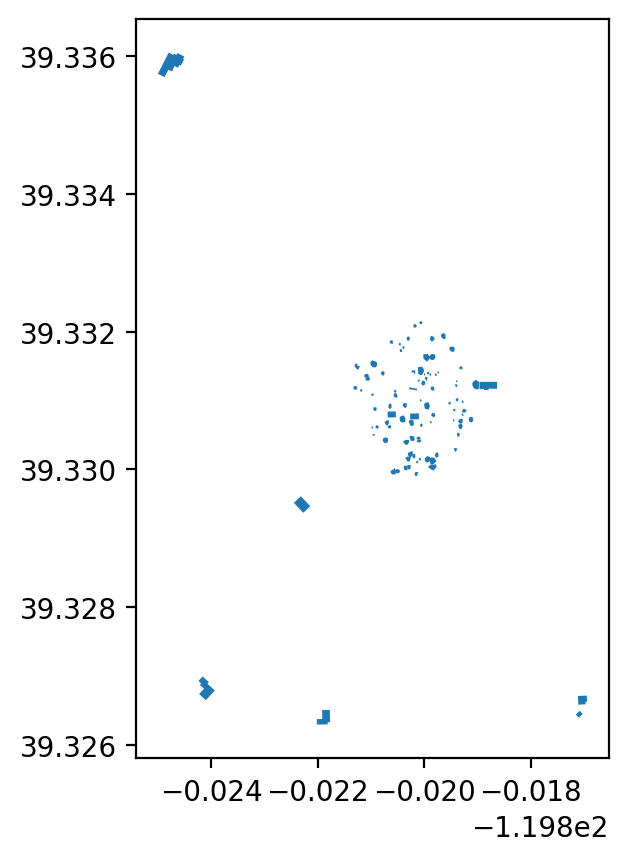

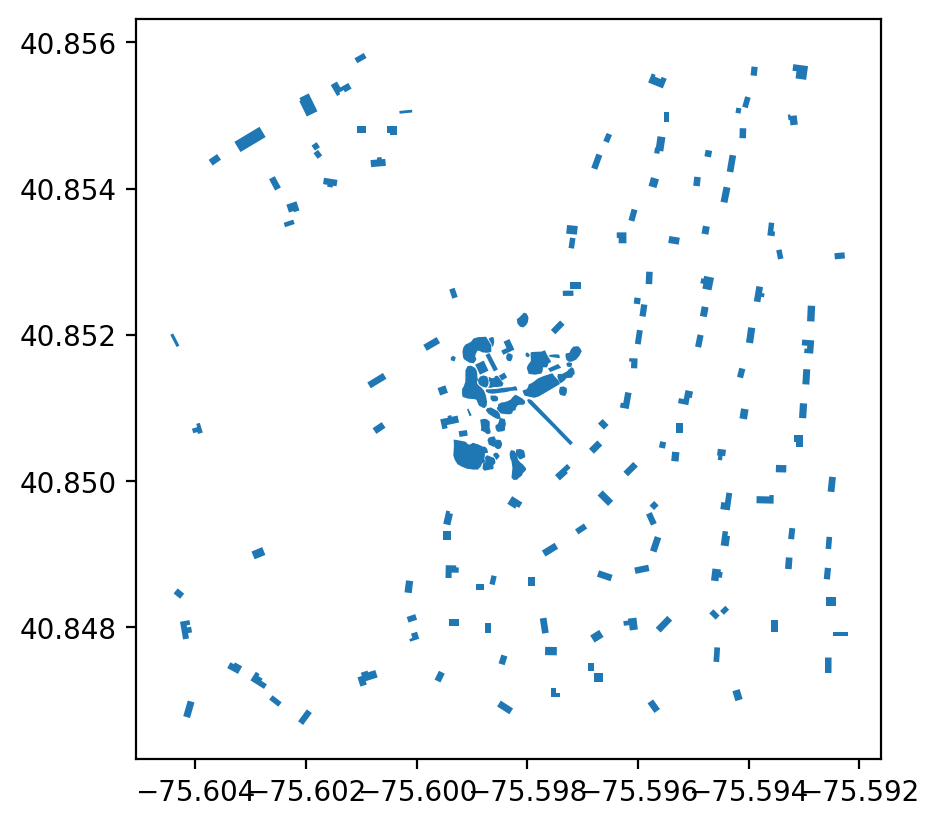

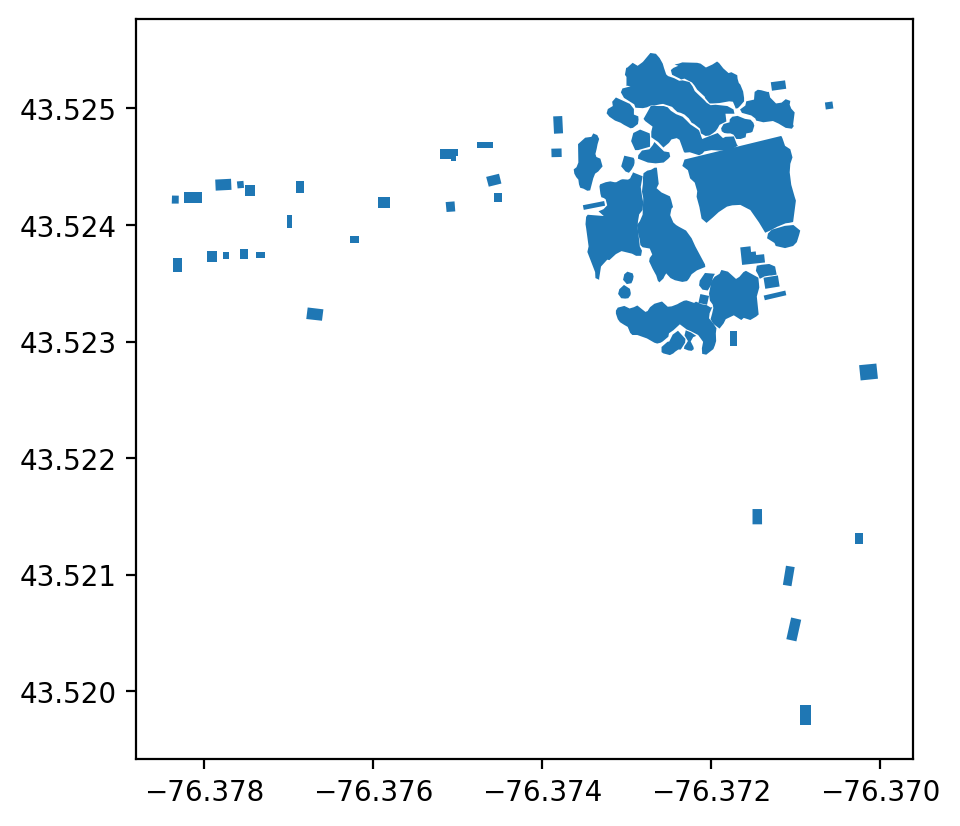

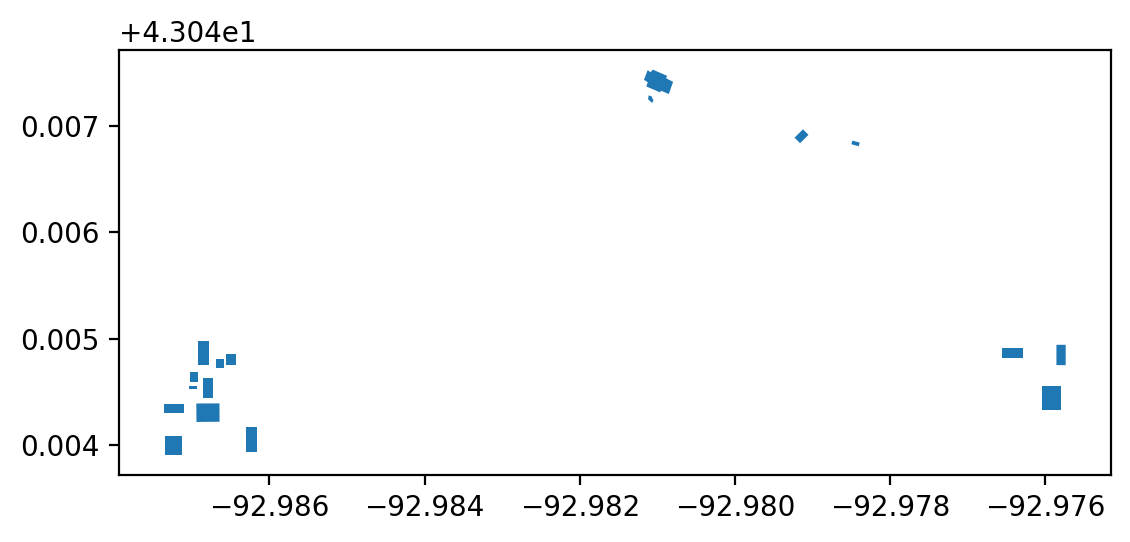

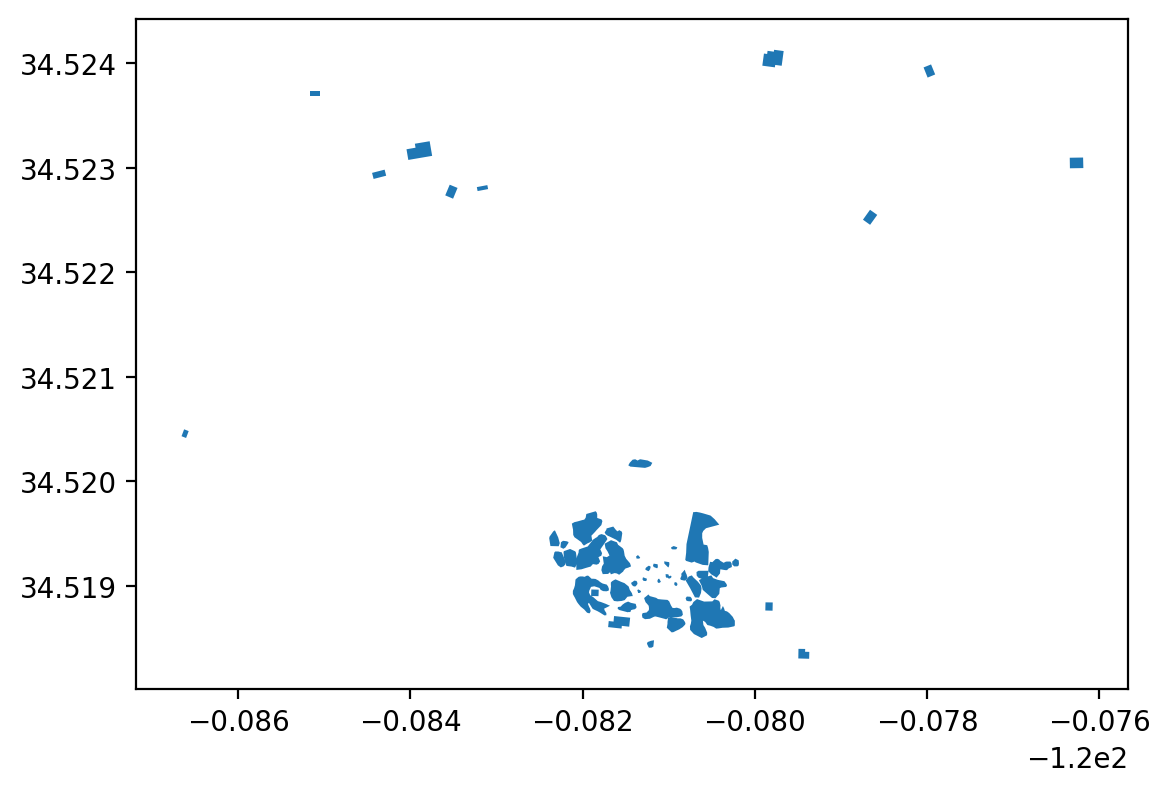

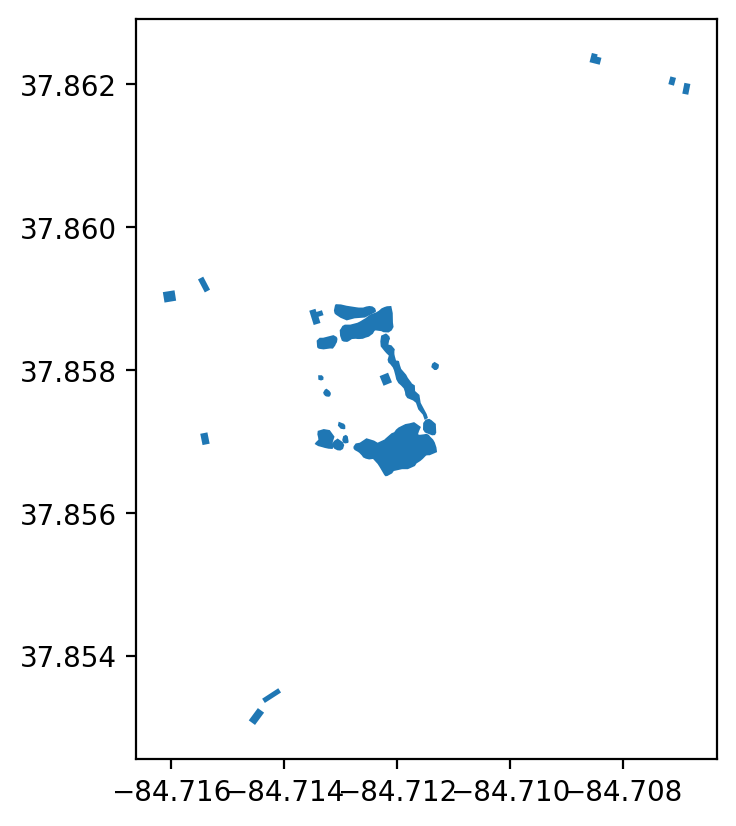

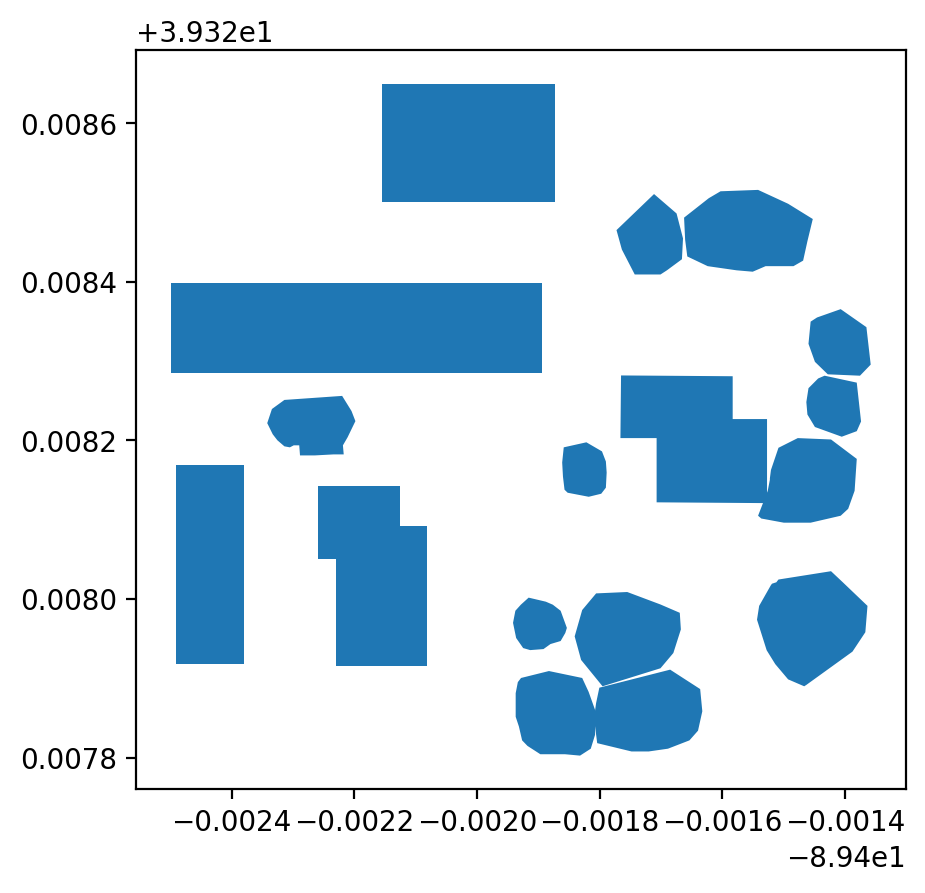

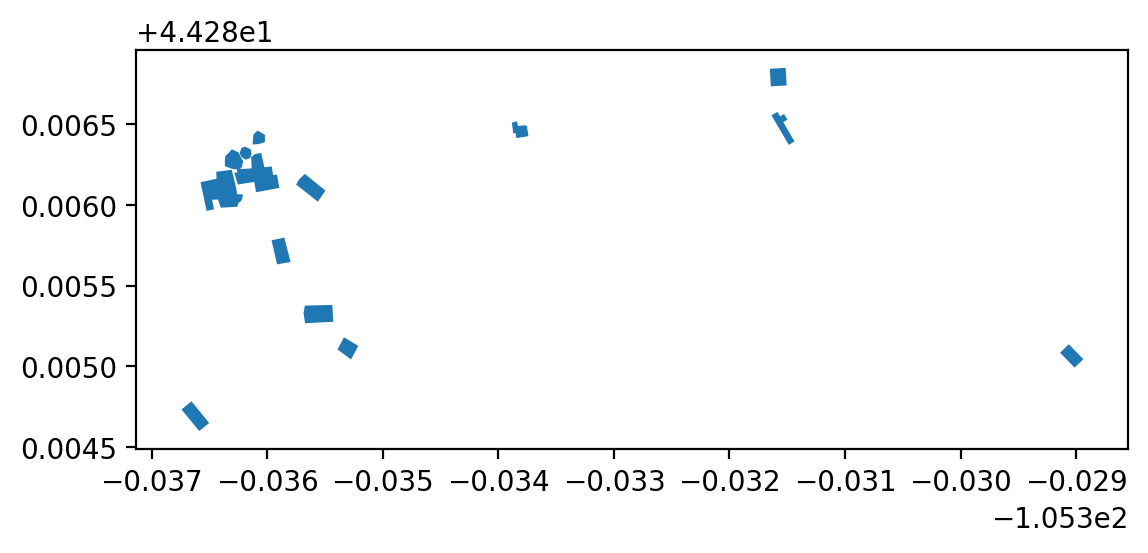

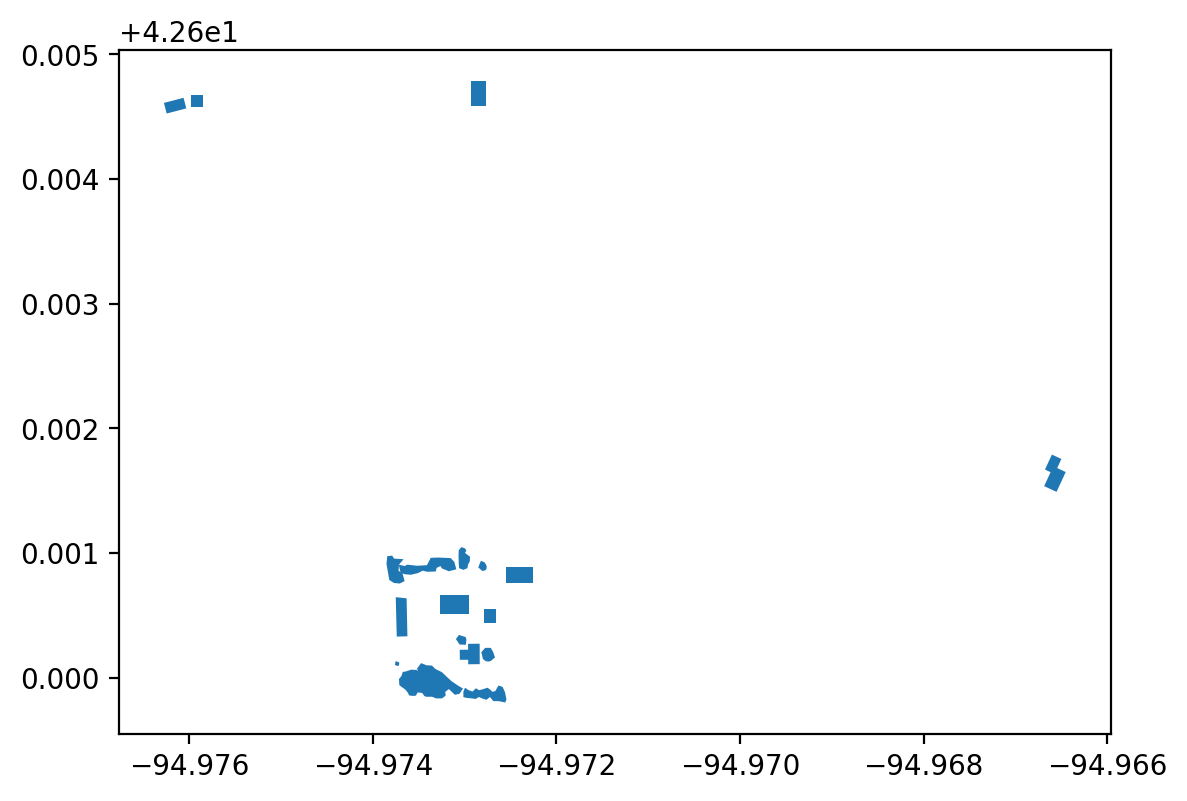

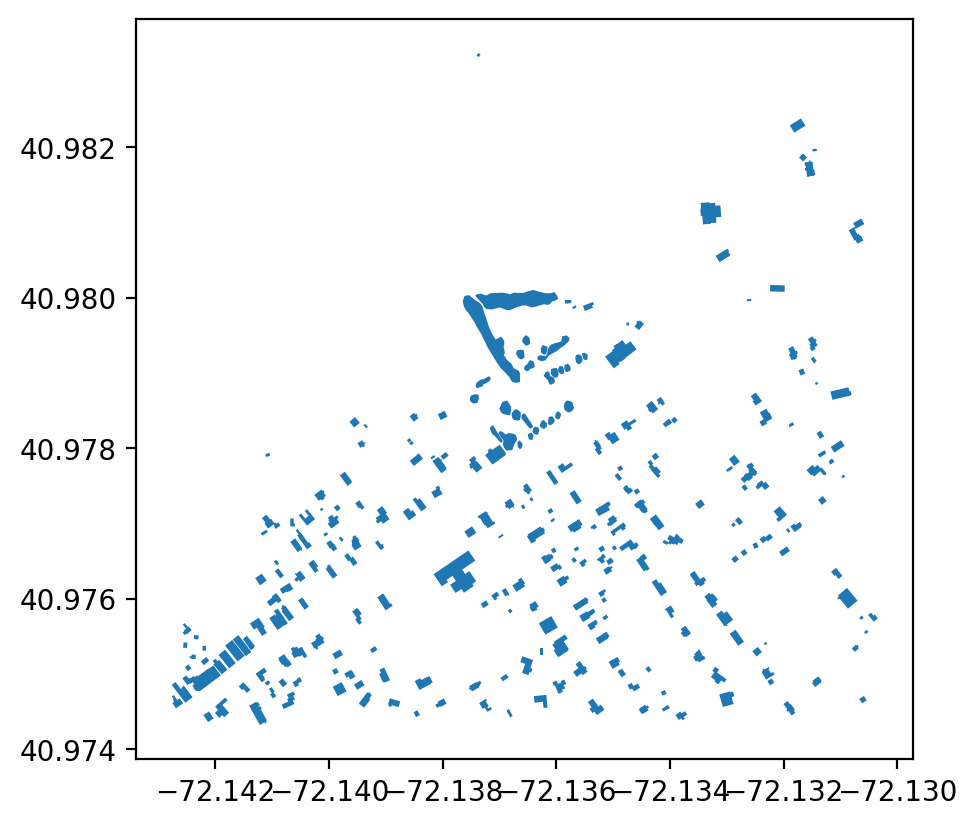

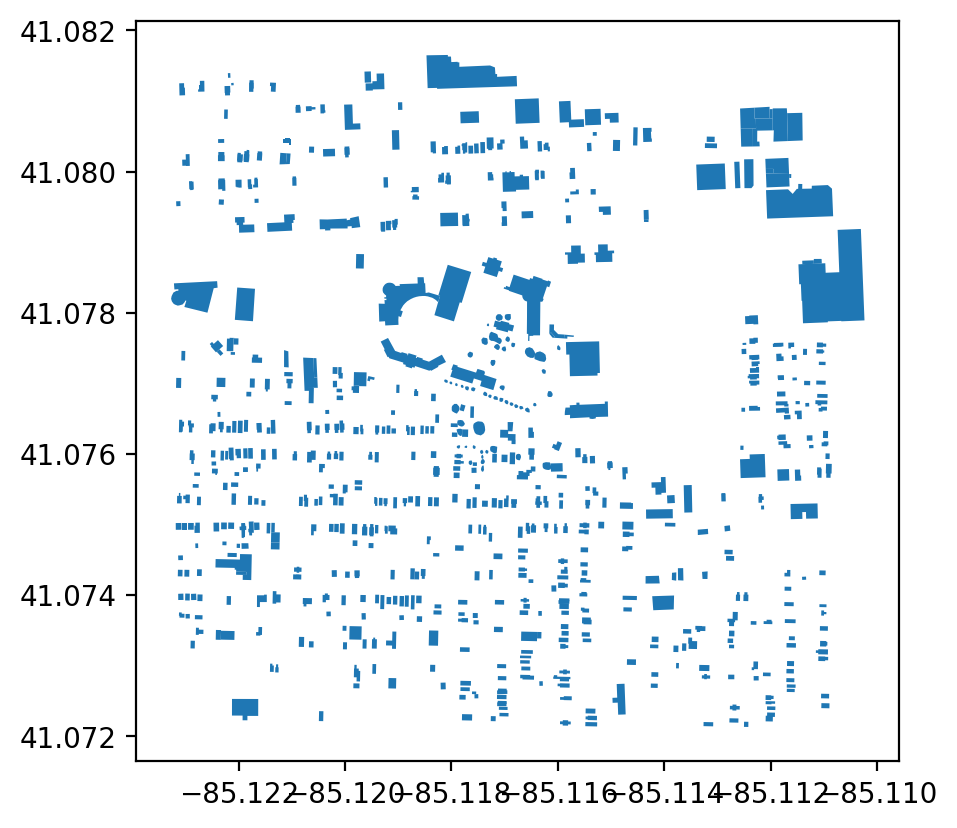

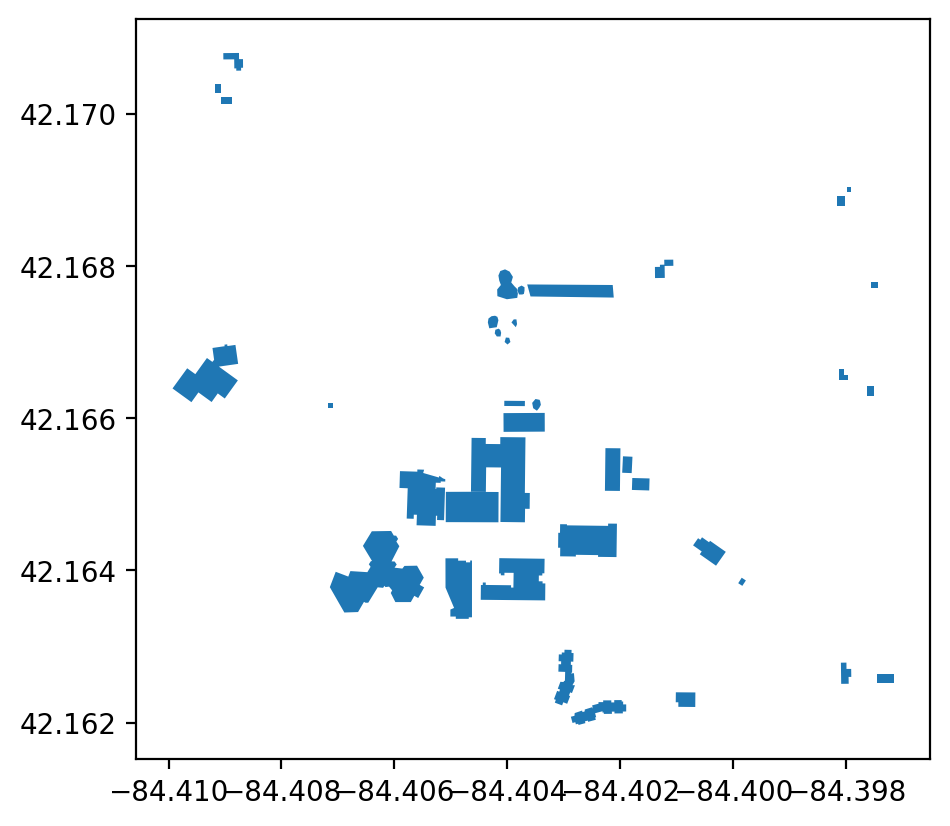

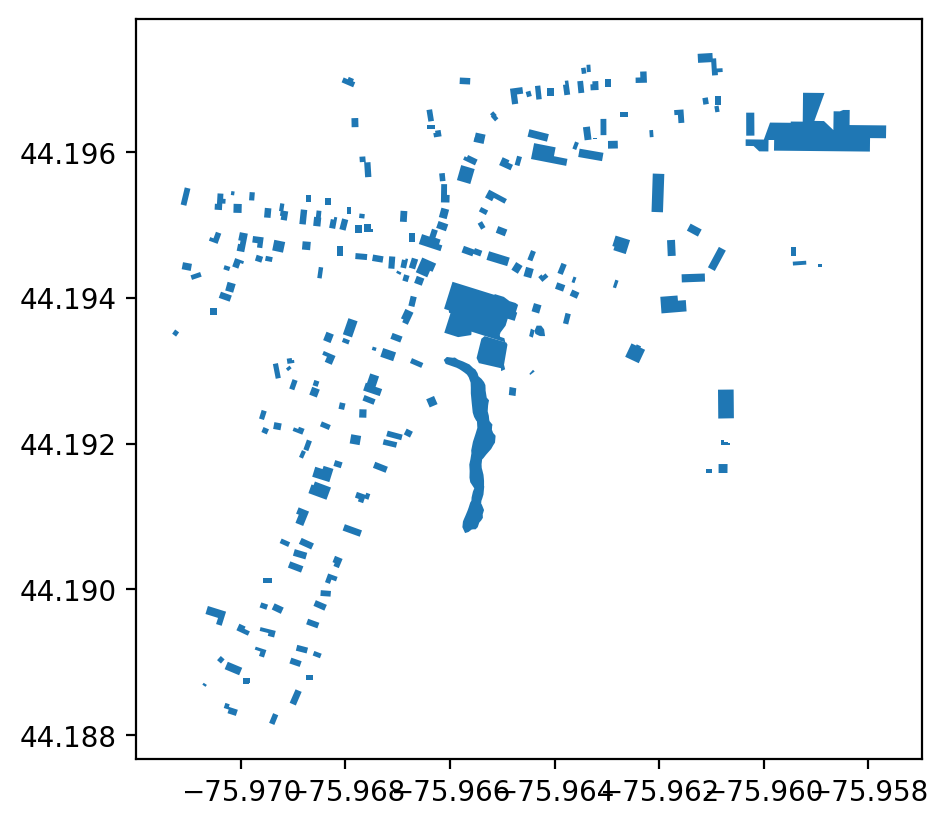

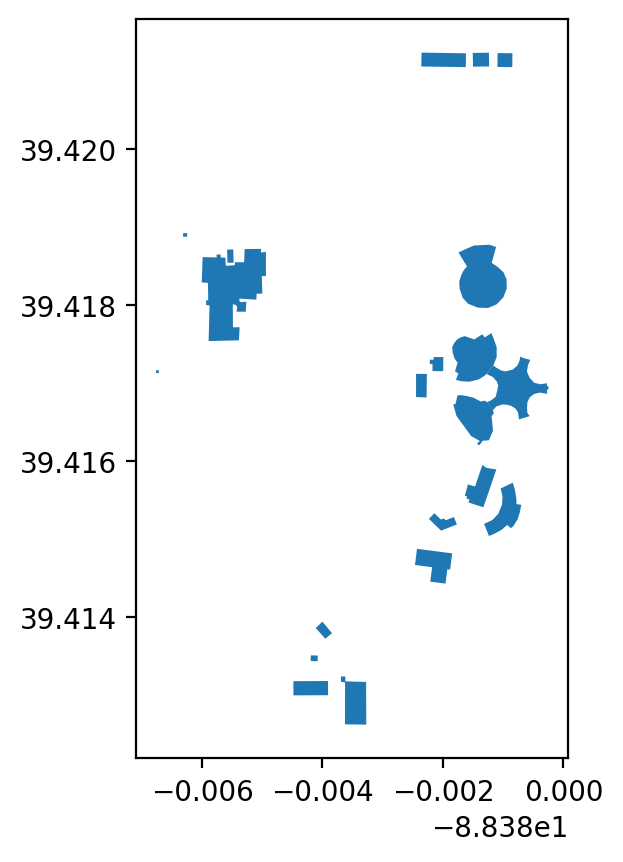

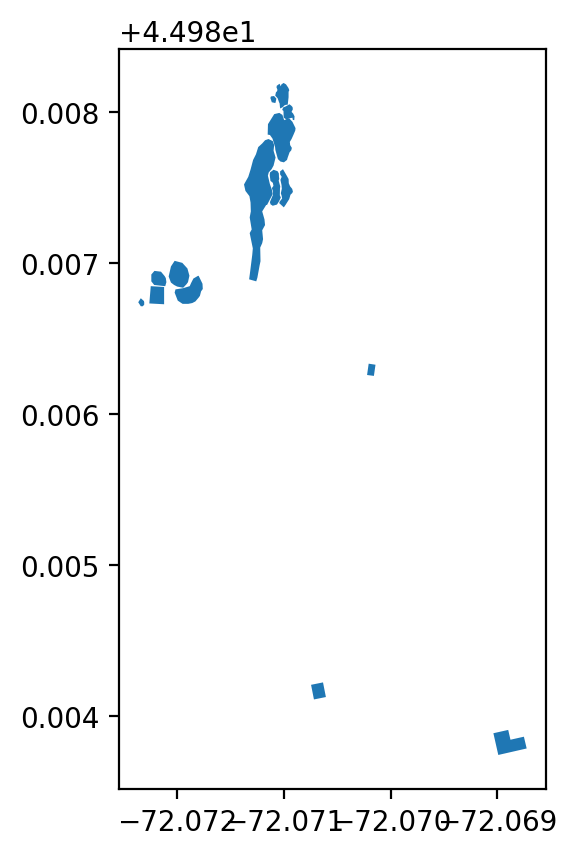

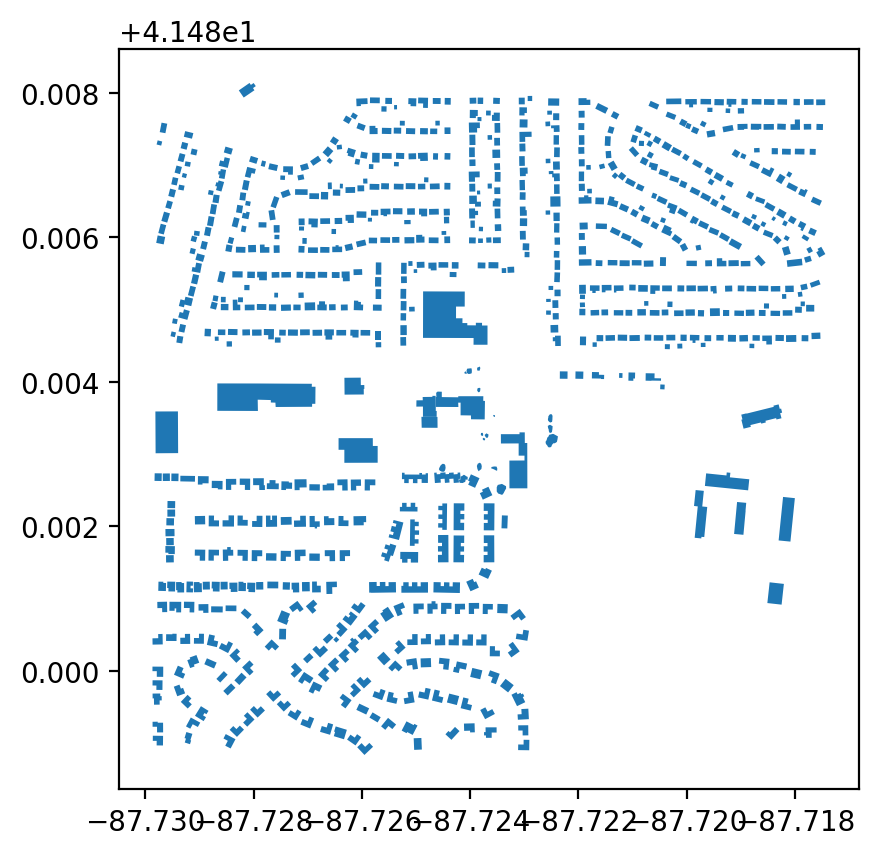

In [10]:
# Quick vis:
for tid, obstacle_df in obstacle_inputs.items():
    obstacle_df.plot()

### Bin wind inputs

In [11]:
dest_dir = "01 Bergey Turbine Data/binned_wind_inputs/"
if os.path.exists(dest_dir):
    shutil.rmtree(dest_dir, ignore_errors=True)
os.makedirs(dest_dir)    
    
# These paths will be passed to QUIC's wrapper script
bins_filepaths = {}

binned_filepaths = {}

for wind_source in wind_sources:
    
    binned_filepaths_curr = {}
    bins_filepaths_curr = {}
    for tid in selected:
    
        print("Processing: %s x %s" % (wind_source, tid))
        
        binned_filename = "%s/%s_%s_binned.csv.bz2" % (dest_dir, wind_source, tid)
        bins_filename = "%s/%s_%s_bins.csv.bz2" % (dest_dir, wind_source, tid)

        # For debugging:
        # atmospheric_inputs[wind_source][tid] -> atmospheric_inputs[wind_source][tid][:X] where X is small
        # to process & save a subset of wind input
        
        if len(atmospheric_inputs[wind_source][tid]) > 0:
            atmospheric_df_binned, atmospheric_bins = \
                wind_binning(atmospheric_inputs[wind_source][tid], wd_bin_width=10.0, ws_bin_width=1.0)
            
            # Note: atmospheric_df_binned["bin_idx"] will point to indices of the rows in atmospheric_bins

            #display(atmospheric_df_binned)
            #display(atmospheric_bins)
            
            atmospheric_df_binned.to_csv(binned_filename, index=False)
            print("Saved wind input file (binned):", binned_filename) 
            atmospheric_bins.to_csv(bins_filename, index=False)
            print("Saved wind input file (bins):", bins_filename) 

            binned_filepaths_curr[tid] = binned_filename
            bins_filepaths_curr[tid] = bins_filename
            
        else: 
            print("wind_source=%s, tid=%s: No atmospheric data found; skipping to the next case." % (wind_source, tid))

            binned_filepaths_curr[tid] = None
            bins_filepaths_curr[tid] = None

    binned_filepaths[wind_source] = binned_filepaths_curr
    bins_filepaths[wind_source] =  bins_filepaths_curr

Processing: wtk x t024
Saved wind input file (binned): 01 Bergey Turbine Data/binned_wind_inputs//wtk_t024_binned.csv.bz2
Saved wind input file (bins): 01 Bergey Turbine Data/binned_wind_inputs//wtk_t024_bins.csv.bz2
Processing: wtk x t028
Saved wind input file (binned): 01 Bergey Turbine Data/binned_wind_inputs//wtk_t028_binned.csv.bz2
Saved wind input file (bins): 01 Bergey Turbine Data/binned_wind_inputs//wtk_t028_bins.csv.bz2
Processing: wtk x t034
Saved wind input file (binned): 01 Bergey Turbine Data/binned_wind_inputs//wtk_t034_binned.csv.bz2
Saved wind input file (bins): 01 Bergey Turbine Data/binned_wind_inputs//wtk_t034_bins.csv.bz2
Processing: wtk x t041
Saved wind input file (binned): 01 Bergey Turbine Data/binned_wind_inputs//wtk_t041_binned.csv.bz2
Saved wind input file (bins): 01 Bergey Turbine Data/binned_wind_inputs//wtk_t041_bins.csv.bz2
Processing: wtk x t083
Saved wind input file (binned): 01 Bergey Turbine Data/binned_wind_inputs//wtk_t083_binned.csv.bz2
Saved wind

### Run QUIC

In [ ]:
def recover_ts_from_binned(binned_filepath, quic_output_filepath):
    """ Convenience function from going from QUIC output back to "unbinned" timeseries dataframe """ 
    binned_df = pd.read_csv(binned_filepath)
    quic_output = pd.read_csv(quic_output_filepath)
    #display(binned_df)
    binned_df["ws-adjusted"] = binned_df["bin_idx"].apply(lambda bin_idx: quic_output.at[bin_idx, "ws-adjusted"])
    return binned_df

# This flag allows overwriting previously saved files with results if they are found in the specified directory dest_dir 
overwrite = False

# Will be used in the filenames
site_type = "bergey"

# Will be used in the filenames
model_type = "lanl"

dest_dir = "03 Model Outputs"
if not os.path.exists(dest_dir):
    os.makedirs(dest_dir)   
    
quic_raw_output_dir = "03 Model Outputs/quic_raw_outputs/"
if not os.path.exists(quic_raw_output_dir):
    os.makedirs(quic_raw_output_dir)   
    
obs_dir = "01 Bergey Turbine Data/quic_obstacle_files/"
if not os.path.exists(obs_dir):
    os.makedirs(obs_dir)    
    
quic_code_dir ="/campaign/tap/QUIC_TAP_API"
quic_exec = "run_quic_mp_v2.py"
script_path = os.path.join(quic_code_dir, quic_exec)
    
cwd = os.getcwd()

for tid in selected:
    
    row = index[index["APRS ID"] == tid].iloc[0]
    #print(row)
    lat = row["Latitude"]
    lon = row["Longitude"]
    z_turbine = row["Hub Height (m)"]
    xy_turbine = [np.array([lon, lat])]
    
    for obstacle_mode in obstacle_modes:  
    
        curr_obs = all_obstacle_inputs[all_obstacle_inputs["tid"] == tid]
        #display(curr_obs)
        
        if obstacle_mode == "bldgsonly":
            obs_df = curr_obs[curr_obs["feature_type"] == "building"].reset_index(drop=True)
        elif obstacle_mode == "bldgsandtrees":
            # Assume trees pass the filtering run above in this notebook  
            print("Error: this modes isn't supported yet! Try other obstacle modes")
            obs_df = obstacle_inputs[tid]
        elif obstacle_mode == "treesasbldgs":
            # Assume trees pass the filtering run above in this notebook 
            obs_df = obstacle_inputs[tid]  
        elif obstacle_mode == "bldgsonly_100m":
            # Assume trees pass the filtering run above in this notebook 
            obs_df = obstacle_inputs[tid] 
            
            #display(obs_df)
            #obs_df.plot()
            obs_df = filter_obstacles(tid,
                                      obs_df,
                                      include_trees=False, 
                                      turbine_height_for_checking=z_turbine,
                                      limit_to_radius_in_m=100.0,
                                      turbine_lat_lon=(lat, lon))
            
            #display(obs_df)
            #obs_df.plot()
        
        if len(obs_df) == 0:
            print("tid=%s: Obstacle set is empty after filtering. ws-adjusted=ws for these cases." % tid)
            # obs_df.to_file() breaks if empty 
            
            for wind_source in wind_sources:
                dest_filename = "%s/%s_%s_%s_%s_%s.csv.bz2" % (dest_dir, site_type, model_type, tid, wind_source, obstacle_mode)
                if (not overwrite) and (os.path.exists(dest_filename)):
                    print("Found previously saved %s); overwrite flag is off. Skipping to next config." % (dest_filename))
                else:
                    if bins_filepaths[wind_source][tid] == None:
                        print("No atmosperic data found for: wind_source=%s, tid=%s" % (wind_source, tid))
                        continue
                recovered_df = atmospheric_inputs[wind_source][tid]
                recovered_df["ws-adjusted"] = recovered_df["ws"]
                recovered_df.to_csv(dest_filename, index=False)  
                print("Saved timeseries output:", dest_filename)
                        
            # Skip the following and go to the next tid x obstacle_mode combination
            continue
            
        
        curr_obs_path = os.path.join(obs_dir, "%s.json" % tid)
        obs_df.to_file(curr_obs_path, driver="GeoJSON", index=False)

        for wind_source in wind_sources:

            dest_filename = "%s/%s_%s_%s_%s_%s.csv.bz2" % (dest_dir, site_type, model_type, tid, wind_source, obstacle_mode)
            if (not overwrite) and (os.path.exists(dest_filename)):
                print("Found previously saved %s); overwrite flag is off. Skipping to next config." % (dest_filename))
            else:
                if bins_filepaths[wind_source][tid] == None:
                    print("No atmosperic data found for: wind_source=%s, tid=%s" % (wind_source, tid))
                    continue

                raw_output_dest = os.path.join(cwd, \
                                               quic_raw_output_dir, \
                                               "quic_raw_output_%s_%s_%s.csv.bz2" % (tid, wind_source, obstacle_mode))

                # Must use subprocess as a way of wrapping/calling the python script becuase that script uses multiprocessing
                # and other methods seem to break
                subprocess.run(["python", script_path,
                                "--atmospheric_file", os.path.join(cwd, bins_filepaths[wind_source][tid]),
                                "--obstacles_file", os.path.join(cwd, curr_obs_path),
                                "--lat", "%f" % lat ,
                                "--lon", "%f" % lon,
                                "--z_turbine", "%f" % z_turbine,
                                "--n_chunks", "36",
                                "--output", raw_output_dest], 
                               stdout=subprocess.DEVNULL, # This addition suppresses entire (lengthy) output
                               cwd=quic_code_dir) # This addition is needed to access QUIC executables inside quic_code_dir directory
                print("Saved raw output:", raw_output_dest)
                
                recovered_df = recover_ts_from_binned(os.path.join(cwd, binned_filepaths[wind_source][tid]),
                                                      raw_output_dest)
                
                # Bring back unbinned ws and wd values
                recovered_df["ws"] = atmospheric_inputs[wind_source][tid]["ws"]
                recovered_df["wd"] = atmospheric_inputs[wind_source][tid]["wd"]
                
                recovered_df.to_csv(dest_filename, index=False)  
                print("Saved recovered timeseries output:", dest_filename)
                #display(recovered_df)

/home/dduplyak/miniconda3/envs/dw-tap/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/dduplyak/miniconda3/envs/dw-tap/lib/python3.8/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/home/dduplyak/miniconda3/envs/dw-tap/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' 

Found previously saved 03 Model Outputs/bergey_lanl_t024_wtk_bldgsonly_100m.csv.bz2); overwrite flag is off. Skipping to next config.
No atmosperic data found for: wind_source=wtk_bc, tid=t024
Found previously saved 03 Model Outputs/bergey_lanl_t028_wtk_bldgsonly_100m.csv.bz2); overwrite flag is off. Skipping to next config.
No atmosperic data found for: wind_source=wtk_bc, tid=t028
Found previously saved 03 Model Outputs/bergey_lanl_t034_wtk_bldgsonly_100m.csv.bz2); overwrite flag is off. Skipping to next config.


/home/dduplyak/miniconda3/envs/dw-tap/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/dduplyak/miniconda3/envs/dw-tap/lib/python3.8/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/home/dduplyak/miniconda3/envs/dw-tap/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' 

Saved raw output: /home/dduplyak/repos/dw-tap-validation/dw-tap/notebooks/validation/03 Model Outputs/quic_raw_outputs/quic_raw_output_t034_wtk_bc_bldgsonly_100m.csv.bz2
Saved recovered timeseries output: 03 Model Outputs/bergey_lanl_t034_wtk_bc_bldgsonly_100m.csv.bz2
Found previously saved 03 Model Outputs/bergey_lanl_t041_wtk_bldgsonly_100m.csv.bz2); overwrite flag is off. Skipping to next config.
No atmosperic data found for: wind_source=wtk_bc, tid=t041
tid=t083: Obstacle set is empty after filtering. ws-adjusted=ws for these cases.
Found previously saved 03 Model Outputs/bergey_lanl_t083_wtk_bldgsonly_100m.csv.bz2); overwrite flag is off. Skipping to next config.


/home/dduplyak/miniconda3/envs/dw-tap/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/dduplyak/miniconda3/envs/dw-tap/lib/python3.8/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/home/dduplyak/miniconda3/envs/dw-tap/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' 

Saved timeseries output: 03 Model Outputs/bergey_lanl_t083_wtk_bldgsonly_100m.csv.bz2
No atmosperic data found for: wind_source=wtk_bc, tid=t083
Found previously saved 03 Model Outputs/bergey_lanl_t114_wtk_bldgsonly_100m.csv.bz2); overwrite flag is off. Skipping to next config.
No atmosperic data found for: wind_source=wtk_bc, tid=t114
Found previously saved 03 Model Outputs/bergey_lanl_t133_wtk_bldgsonly_100m.csv.bz2); overwrite flag is off. Skipping to next config.
Found previously saved 03 Model Outputs/bergey_lanl_t133_wtk_bc_bldgsonly_100m.csv.bz2); overwrite flag is off. Skipping to next config.


/home/dduplyak/miniconda3/envs/dw-tap/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/dduplyak/miniconda3/envs/dw-tap/lib/python3.8/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/home/dduplyak/miniconda3/envs/dw-tap/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' 

Found previously saved 03 Model Outputs/bergey_lanl_t135_wtk_bldgsonly_100m.csv.bz2); overwrite flag is off. Skipping to next config.
No atmosperic data found for: wind_source=wtk_bc, tid=t135


/home/dduplyak/miniconda3/envs/dw-tap/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/dduplyak/miniconda3/envs/dw-tap/lib/python3.8/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/home/dduplyak/miniconda3/envs/dw-tap/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' 

Saved raw output: /home/dduplyak/repos/dw-tap-validation/dw-tap/notebooks/validation/03 Model Outputs/quic_raw_outputs/quic_raw_output_t139_wtk_bldgsonly_100m.csv.bz2
Saved recovered timeseries output: 03 Model Outputs/bergey_lanl_t139_wtk_bldgsonly_100m.csv.bz2
No atmosperic data found for: wind_source=wtk_bc, tid=t139
tid=t140: Obstacle set is empty after filtering. ws-adjusted=ws for these cases.


/home/dduplyak/miniconda3/envs/dw-tap/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/dduplyak/miniconda3/envs/dw-tap/lib/python3.8/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/home/dduplyak/miniconda3/envs/dw-tap/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' 

Saved timeseries output: 03 Model Outputs/bergey_lanl_t140_wtk_bldgsonly_100m.csv.bz2
Saved timeseries output: 03 Model Outputs/bergey_lanl_t140_wtk_bc_bldgsonly_100m.csv.bz2


/home/dduplyak/miniconda3/envs/dw-tap/lib/python3.8/site-packages/dw_tap-0.0.1-py3.8.egg/dw_tap/data_processing.py:327: UserWarning: (tid: t169) Detected at least 1 obstacle that is as tall as the studied turbine:
        height feature_type                                           geometry
1    47.690002     building  POLYGON ((-85.12322 41.07841, -85.12321 41.078...
4    38.265015     building  POLYGON ((-85.12048 41.07932, -85.12047 41.079...
5    37.169983     building  POLYGON ((-85.11821 41.07941, -85.11821 41.079...
20   40.309998     building  POLYGON ((-85.11423 41.07398, -85.11421 41.073...
174  59.519958     building  POLYGON ((-85.11854 41.07733, -85.11854 41.077...
176  43.849976     building  POLYGON ((-85.11506 41.07897, -85.11524 41.078...
177  43.159973     building  POLYGON ((-85.11557 41.07895, -85.11575 41.078...
600  40.349976     building  POLYGON ((-85.11578 41.07669, -85.11577 41.076...
  warnings.warn("(tid: %s) Detected at least 1 obstacle that is as tall as 

Saved raw output: /home/dduplyak/repos/dw-tap-validation/dw-tap/notebooks/validation/03 Model Outputs/quic_raw_outputs/quic_raw_output_t169_wtk_bldgsonly_100m.csv.bz2
Saved recovered timeseries output: 03 Model Outputs/bergey_lanl_t169_wtk_bldgsonly_100m.csv.bz2
No atmosperic data found for: wind_source=wtk_bc, tid=t169
tid=t170: Obstacle set is empty after filtering. ws-adjusted=ws for these cases.


/home/dduplyak/miniconda3/envs/dw-tap/lib/python3.8/site-packages/dw_tap-0.0.1-py3.8.egg/dw_tap/data_processing.py:327: UserWarning: (tid: t170) Detected at least 1 obstacle that is as tall as the studied turbine:
       height feature_type                                           geometry
0   38.170044     building  POLYGON ((-84.40688 42.16345, -84.40664 42.163...
1   27.420502     building  POLYGON ((-84.40590 42.16530, -84.40591 42.165...
2   35.169006     building  POLYGON ((-84.40509 42.16416, -84.40509 42.163...
3   36.310974     building  POLYGON ((-84.40508 42.16503, -84.40509 42.164...
4   24.216980     building  POLYGON ((-84.40438 42.16503, -84.40437 42.165...
5   26.520996     building  POLYGON ((-84.40446 42.16381, -84.40447 42.163...
11  31.554993     building  POLYGON ((-84.40306 42.16461, -84.40306 42.164...
14  32.375977     building  POLYGON ((-84.40287 42.16208, -84.40284 42.162...
15  32.007996     building  POLYGON ((-84.40315 42.16226, -84.40302 42.162...
17  28

Saved timeseries output: 03 Model Outputs/bergey_lanl_t170_wtk_bldgsonly_100m.csv.bz2
Saved timeseries output: 03 Model Outputs/bergey_lanl_t170_wtk_bc_bldgsonly_100m.csv.bz2


/home/dduplyak/miniconda3/envs/dw-tap/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/dduplyak/miniconda3/envs/dw-tap/lib/python3.8/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/home/dduplyak/miniconda3/envs/dw-tap/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' 

Saved raw output: /home/dduplyak/repos/dw-tap-validation/dw-tap/notebooks/validation/03 Model Outputs/quic_raw_outputs/quic_raw_output_t182_wtk_bldgsonly_100m.csv.bz2
Saved recovered timeseries output: 03 Model Outputs/bergey_lanl_t182_wtk_bldgsonly_100m.csv.bz2
No atmosperic data found for: wind_source=wtk_bc, tid=t182


/home/dduplyak/miniconda3/envs/dw-tap/lib/python3.8/site-packages/dw_tap-0.0.1-py3.8.egg/dw_tap/data_processing.py:327: UserWarning: (tid: t183) Detected at least 1 obstacle that is as tall as the studied turbine:
       height feature_type                                           geometry
2   32.928497     building  POLYGON ((-88.38162 39.42123, -88.38236 39.421...
8   27.808502     building  POLYGON ((-88.38124 39.42124, -88.38151 39.421...
11  28.283997     building  POLYGON ((-88.38085 39.42123, -88.38109 39.421...
20  43.803497     building  POLYGON ((-88.38676 39.41717, -88.38676 39.417...
  warnings.warn("(tid: %s) Detected at least 1 obstacle that is as tall as the studied turbine:\n%s" % \
/home/dduplyak/miniconda3/envs/dw-tap/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.gith

In [22]:
# Quick vis of data in produced files

# for f in glob.iglob("%s/*" % dest_dir):
#     df = pd.read_csv(f)
#     fig = plt.gcf()
#     fig.set_size_inches(2.5,2.5)
#     sns.scatterplot(x=df["ws"], \
#                     y=df["ws-adjusted"], alpha=0.2).set(title=os.path.basename(f));
#     plt.show()